# Notebook for reformatting multimodal datasets (RNA+ATAC) 

We use RNA/GEX interchangeably. (We will call ATAC as just ATAC).

This is very similar to RNA+ADT notebook in terms of the fact that the cells are shared between the two modalities. We just need to be careful with the following
- (1) cell_id being consistent when merging
- (2) each modalities are normalized separately
- (3) keeping the embeddings from both modalities.

## Note that this object is already concatenated with multiple donors, as well as the count matrix already has the form of cell x (RNA+ATAC) format.

What we will do:
- subset for only one site/donor (s1d1)
- rename the var with each modality (either RNA or ATAC)
- redo the log-normalization for each modality, then merge (this is pretty much for visualization only)

In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import sys
import os
from scipy import sparse

In [2]:
adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/multiome_BMMC_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [3]:
adata.obs.batch

TAGTTGTCACCCTCAC-1-s1d1     s1d1
CTATGGCCATAACGGG-1-s1d1     s1d1
CCGCACACAGGTTAAA-1-s1d1     s1d1
TCATTTGGTAATGGAA-1-s1d1     s1d1
ACCACATAGGTGTCCA-1-s1d1     s1d1
                            ... 
AAACCGCGTTTGAGGC-12-s4d9    s4d9
TGACTTAAGTTCCCGT-12-s4d9    s4d9
GCTGTACCACCGTTCC-12-s4d9    s4d9
ACACTTGCAACTAGAA-12-s4d9    s4d9
CACTTAAAGTCTGGGC-12-s4d9    s4d9
Name: batch, Length: 69249, dtype: category
Categories (13, object): ['s1d1', 's1d2', 's1d3', 's2d1', ..., 's3d10', 's4d1', 's4d8', 's4d9']

In [4]:
# subset for one dataset - s1d1 using the "batch" key. Note that we can also use "Site" and "DonorNumber" keys.
adata_s1d1 = adata[adata.obs.batch=="s1d1"]

adata_s1d1

del adata

In [5]:
adata_s1d1

View of AnnData object with n_obs × n_vars = 6224 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Preprocess the ATAC dataset

- ATAC dataset has the format of cells x peaks. 
- We want to map the "peaks" to "genes" so that we can see the correlation between RNA and ATAC for different cell-types.
- In neurips 2021 (open problems), this task was done using Signac package. The resulting cell x gene count matrix (raw counts) is saved in adata.obsm["ATAC_gene_activity"], and the gene names are saved in adata.uns["ATAC_gene_activity_var_names"].
- 


In [26]:
adata_s1d1.uns["ATAC_gene_activity_var_names"]

array(['OR4F5', 'OR4F29', 'OR4F16', ..., 'DAZ4', 'BPY2C', 'CDY1'],
      dtype=object)

In [23]:
np.sum(adata_s1d1.obsm["ATAC_gene_activity"].todense(),1)
# the counts are "raw", not log-normalized just yet.

matrix([[4082.0847],
        [4981.3896],
        [4335.945 ],
        ...,
        [4387.2207],
        [3710.1345],
        [5052.951 ]], dtype=float32)

In [53]:
# subset the ATAC part of the object by creating a new anndata obje
adata_s1d1_ATAC = ad.AnnData(X = adata_s1d1.obsm["ATAC_gene_activity"],
                             obs = adata_s1d1.obs,
                             obsm = adata_s1d1.obsm)
adata_s1d1_ATAC.var_names = adata_s1d1.uns["ATAC_gene_activity_var_names"]
# save the raw counts
adata_s1d1_ATAC.layers["counts"] = adata_s1d1_ATAC.X.copy()
adata_s1d1_ATAC
# adata_s1d1_ATAC.X = adata_s1d1.obsm["ATAC_gene_activity"]

AnnData object with n_obs × n_vars = 6224 × 19039
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [86]:
# log-normalize the counts in adata_s1d1_ATAC
sc.pp.normalize_total(adata_s1d1_ATAC, target_sum=1e4)
sc.pp.log1p(adata_s1d1_ATAC)

In [125]:
# subset the RNA part of the object (cell x gene(RNA))
adata_s1d1_RNA = adata_s1d1[:,adata_s1d1.var.feature_types=="GEX"]
adata_s1d1_RNA

View of AnnData object with n_obs × n_vars = 6224 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## compute leiden clustering for each modality

- this functionality does not work in exCellxgene currently. (needs some debugging on what the exCellxgene grabs in the backend).

In [126]:
# need to specify which PCA, and keys to be used
sc.pp.neighbors(adata_s1d1_RNA, n_neighbors=10, n_pcs=40, use_rep="GEX_X_pca", key_added="GEX")

In [76]:
adata_s1d1_RNA

AnnData object with n_obs × n_vars = 6224 × 17813
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'GEX'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
    obsp: 'GEX_distances', 'GEX_connectivities'

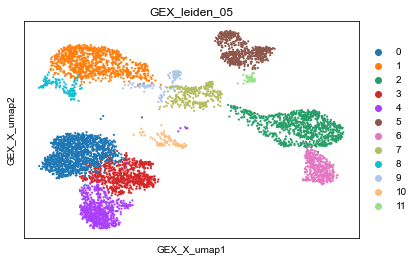

In [130]:
# compute the leiden clustering
sc.tl.leiden(adata_s1d1_RNA, key_added="GEX_leiden_05", neighbors_key="GEX", resolution=0.5)
sc.pl.embedding(adata_s1d1_RNA, basis="GEX_X_umap", color="GEX_leiden_05")

In [131]:
sc.tl.leiden(adata_s1d1_RNA, key_added="GEX_leiden_03", neighbors_key="GEX", resolution=0.3)
sc.tl.leiden(adata_s1d1_RNA, key_added="GEX_leiden_04", neighbors_key="GEX", resolution=0.4)
sc.tl.leiden(adata_s1d1_RNA, key_added="GEX_leiden_06", neighbors_key="GEX", resolution=0.6)

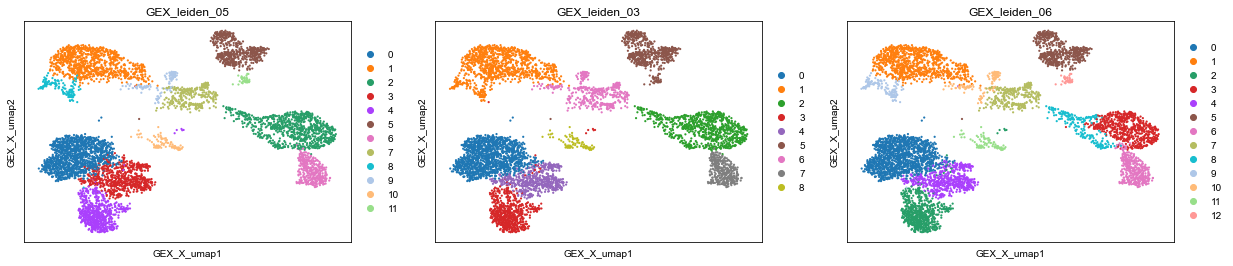

In [132]:
sc.pl.embedding(adata_s1d1_RNA, basis="GEX_X_umap", 
                color=["GEX_leiden_05", "GEX_leiden_03","GEX_leiden_06"])

### ATAC

In [87]:
adata_s1d1_ATAC

AnnData object with n_obs × n_vars = 6224 × 19039
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    uns: 'log1p'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [88]:
# need to specify which PCA, and keys to be used
sc.pp.neighbors(adata_s1d1_ATAC, n_neighbors=10, n_pcs=40, use_rep="ATAC_lsi_full", key_added="ATAC")

In [113]:
# define the Dark2 color palette
# dark2 = plt.get_cmap('Dark2').colors
dark2 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666']

# add new colors to the palette
new_colors = ['#A95C68', '#587B7F', '#8B6D9C']
dark2_extended = dark2 + new_colors

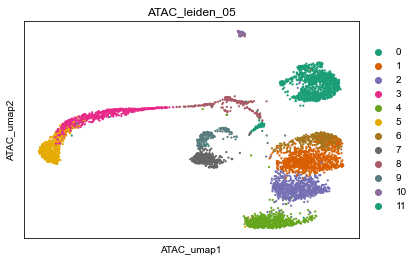

In [115]:
# compute the leiden clustering
sc.tl.leiden(adata_s1d1_ATAC, key_added="ATAC_leiden_05", neighbors_key="ATAC", resolution = 0.5)
sc.pl.embedding(adata_s1d1_ATAC, basis="ATAC_umap", color="ATAC_leiden_05", palette=dark2_extended) 

In [92]:
adata_s1d1_ATAC

AnnData object with n_obs × n_vars = 6224 × 19039
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'ATAC_leiden'
    uns: 'log1p', 'ATAC', 'leiden'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
    obsp: 'ATAC_distances', 'ATAC_connectivities'

In [163]:
['#1f77b4', '#ff7f0e', '#279e68', '#d62728', 
 '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', 
 '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

OverloadedDict, wrapping:
	{'ATAC_gene_activity_var_names': array(['OR4F5', 'OR4F29', 'OR4F16', ..., 'DAZ4', 'BPY2C', 'CDY1'],
      dtype=object), 'dataset_id': 'openproblems_bmmc_multiome', 'genome': 'GRCh38', 'organism': 'human', 'GEX': {'connectivities_key': 'GEX_connectivities', 'distances_key': 'GEX_distances', 'params': {'n_neighbors': 10, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'use_rep': 'GEX_X_pca', 'n_pcs': 40}}, 'leiden': {'params': {'resolution': 0.6, 'random_state': 0, 'n_iterations': -1}}, 'GEX_leiden_05_colors': ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896'], 'GEX_leiden_03_colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22'], 'GEX_leiden_06_colors': ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']}
With ov

In [169]:
pip install pySankey==0.0.1


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [170]:
from pysankey import sankey

# define the colors as the Set1 as the RNA clusters
colors = {
    "0": "#1f77b4",
    "1": "#ff7f0e",
    "2": "#279e68",
    "3": "#d62728",
    "4": "#aa40fc",
    "5": '#8c564b',
    "6": '#e377c2',
    "7": '#b5bd61',
    "8": '#17becf',
    "9": "#aec7e8",
    "10": "#ffbb78",
    "11":"#98df8a",
    "12":"#ff9896"
}


sankey(adata_joint.obs["GEX_leiden_05"], adata_joint.obs["ATAC_leiden_05"], aspect=20, colorDict=colors, fontsize=12)
# plt.savefig("GEX_ADT_leiden_sankey.pdf", dpi=300)

ModuleNotFoundError: No module named 'pysankey'

# Subset the data for each modality (assay) - RNA and ADT

## GEX

In [134]:
# # subset for GEX assay
# adata_GEX = adata_s1d1[:,adata_s1d1.var.feature_types=="GEX"]
# adata_GEX

adata_GEX = adata_s1d1_RNA.copy()
adata_GEX

AnnData object with n_obs × n_vars = 6224 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'GEX_leiden_05', 'GEX_leiden_03', 'GEX_leiden_04', 'GEX_leiden_06'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'GEX', 'leiden', 'GEX_leiden_05_colors', 'GEX_leiden_03_colors', 'GEX_leiden_06_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
    obsp: 'GEX_distances', 'GEX_connectivities'

In [93]:
# # recover the raw counts in the adata_GEX.X
# adata_GEX.X = adata_GEX.layers["counts"].copy()

# # log-normalization for RNA(GEX) counts
# sc.pp.normalize_total(adata_GEX, target_sum=1e4)
# sc.pp.log1p(adata_GEX)
# adata_GEX.raw = adata_GEX.copy()


In [96]:
# # check the log-normalization
# np.sum(np.expm1(adata_GEX.X.todense()),1)

matrix([[10000.   ],
        [ 9999.999],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.   ],
        [10000.   ]], dtype=float32)

In [135]:
# Add the modality/assay to the var_names 
adata_GEX.var_names = adata_GEX.var_names+"-RNA"
adata_GEX.var_names

Index(['AL627309.5-RNA', 'LINC01409-RNA', 'LINC01128-RNA', 'NOC2L-RNA',
       'KLHL17-RNA', 'ISG15-RNA', 'C1orf159-RNA', 'SDF4-RNA', 'B3GALT6-RNA',
       'UBE2J2-RNA',
       ...
       'MT-ATP6-RNA', 'MT-CO3-RNA', 'MT-ND3-RNA', 'MT-ND4L-RNA', 'MT-ND4-RNA',
       'MT-ND5-RNA', 'MT-ND6-RNA', 'MT-CYB-RNA', 'AL592183.1-RNA',
       'AC240274.1-RNA'],
      dtype='object', length=13431)

In [136]:
adata_GEX

AnnData object with n_obs × n_vars = 6224 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'GEX_leiden_05', 'GEX_leiden_03', 'GEX_leiden_04', 'GEX_leiden_06'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'GEX', 'leiden', 'GEX_leiden_05_colors', 'GEX_leiden_03_colors', 'GEX_leiden_06_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
    obsp: 'GEX_distances', 'GEX_connectivities'

## ATAC

In [138]:
# adata_ATAC = adata_s1d1[:,adata_s1d1.var.feature_types=="ATAC"]
# adata_ATAC
adata_ATAC = adata_s1d1_ATAC.copy()
adata_ATAC

AnnData object with n_obs × n_vars = 6224 × 19039
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'ATAC_leiden', 'ATAC_leiden_05', 'ATAC_leiden_03', 'ATAC_leiden_04'
    uns: 'log1p', 'ATAC', 'leiden', 'ATAC_leiden_colors', 'ATAC_leiden_05_colors', 'ATAC_leiden_03_colors', 'ATAC_leiden_04_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
    obsp: 'ATAC_distances', 'ATAC_connectivities'

In [139]:
# Add the modality/assay to the var_names 
adata_ATAC.var_names = adata_ATAC.var_names+"-ATAC"
adata_ATAC.var_names

Index(['OR4F5-ATAC', 'OR4F29-ATAC', 'OR4F16-ATAC', 'SAMD11-ATAC', 'NOC2L-ATAC',
       'KLHL17-ATAC', 'PLEKHN1-ATAC', 'PERM1-ATAC', 'HES4-ATAC', 'ISG15-ATAC',
       ...
       'BPY2-ATAC', 'DAZ1-ATAC', 'DAZ2-ATAC', 'PRYP3-ATAC', 'CDY1B-ATAC',
       'BPY2B-ATAC', 'DAZ3-ATAC', 'DAZ4-ATAC', 'BPY2C-ATAC', 'CDY1-ATAC'],
      dtype='object', length=19039)

# Merge the two adata objects (RNA and ATAC)

In [140]:
del adata_GEX.raw
del adata_ATAC.raw

In [141]:
# concatenate the two adata objects
adata_joint = ad.concat([adata_GEX, adata_ATAC], axis=1, merge="first")
adata_joint

AnnData object with n_obs × n_vars = 6224 × 32470
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'GEX_leiden_05', 'GEX_leiden_03', 'GEX_leiden_04', 'GEX_leiden_06', 'ATAC_leiden', 'ATAC_leiden_05', 'ATAC_leiden_03', 'ATAC_leiden_04'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
    obsp: 'GEX_distances', 'GEX_connectivities', 'ATAC_distances', 'ATAC_connectivities'

In [142]:
adata_joint.uns

OverloadedDict, wrapping:
	OrderedDict()
With overloaded keys:
	['neighbors'].

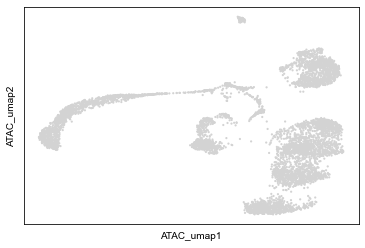

In [143]:
sc.pl.embedding(adata_joint, basis="ATAC_umap")

In [144]:
adata_joint.var

""
AL627309.5-RNA
LINC01409-RNA
LINC01128-RNA
NOC2L-RNA
KLHL17-RNA
...
BPY2B-ATAC
DAZ3-ATAC
DAZ4-ATAC
BPY2C-ATAC


In [177]:
# adata_joint.var

,feature_types
AL627309.5-RNA,GEX
LINC01409-RNA,GEX
LINC01128-RNA,GEX
LINC00115-RNA,GEX
FAM41C-RNA,GEX
...,...
HLA-E-ADT,ADT
CD82-ADT,ADT
CD101-ADT,ADT
CD88-ADT,ADT


In [157]:
adata_joint.obsm["ATAC_X_umap"] = adata_joint.obsm["ATAC_umap"]
del adata_joint.obsm["ATAC_umap"]

In [159]:
adata_joint

AnnData object with n_obs × n_vars = 6224 × 32470
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'GEX_leiden_05', 'GEX_leiden_03', 'GEX_leiden_04', 'GEX_leiden_06', 'ATAC_leiden', 'ATAC_leiden_05', 'ATAC_leiden_03', 'ATAC_leiden_04'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'GEX_X_pca', 'GEX_X_umap', 'ATAC_X_umap'
    layers: 'counts'
    obsp: 'GEX_distances', 'GEX_connectivities', 'ATAC_distances', 'ATAC_connectivities'

In [145]:
adata_GEX.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_processed_v2.h5ad")

In [147]:
adata_ATAC.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_atac_processed_v2.h5ad")

In [148]:
adata_joint.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_processed_v2.h5ad")

In [160]:
adata_test = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint.h5ad")
adata_test

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC'
    var: 'assay'
    obsm: 'X_pca', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'connectivities', 'distances'

In [161]:
del adata_test.obsp
adata_test



AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC'
    var: 'assay'
    obsm: 'X_pca', 'X_umap_ATAC', 'X_umap_RNA'

In [162]:
adata_test.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_v2.h5ad")